# **Data Import**

In [11]:
import gzip
import numpy as np
import os
import requests 
from sklearn.svm import SVC, LinearSVC
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc
import matplotlib.pyplot as plt

from scipy import interp
from itertools import cycle
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score



 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def load_mnist(train_data=True, test_data=False):
    RESOURCES = [
        'train-images-idx3-ubyte.gz',
        'train-labels-idx1-ubyte.gz',
        't10k-images-idx3-ubyte.gz',
        't10k-labels-idx1-ubyte.gz']
    if (os.path.isdir('data') == 0):
        os.mkdir('data')
    if (os.path.isdir('data/mnist') == 0):
        os.mkdir('data/mnist')
    for name in RESOURCES:
        if (os.path.isfile('data/mnist/'+name) == 0):
            url = 'http://yann.lecun.com/exdb/mnist/'+name
            r = requests.get(url, allow_redirects=True)
            open('data/mnist/'+name, 'wb').write(r.content)
    return get_images(train_data, test_data), get_labels(train_data, test_data)
    #train_data = get_images(train_data)
    #test_data = get_images(test_data)
    #train_lable = get_labels(train_data)
    #test_lable = get_labels(test_data)
    #return train_data, test_data, train_lable, test_lable

In [4]:
load_mnist(train_data=True, test_data=True)

(array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        ...,
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],

In [3]:
def get_images(train_data=True, test_data=False):
    to_return = []
    if train_data:
        with gzip.open('data/mnist/train-images-idx3-ubyte.gz', 'r') as f:
            # first 4 bytes is a magic number
            magic_number = int.from_bytes(f.read(4), 'big')
            # second 4 bytes is the number of images
            image_count = int.from_bytes(f.read(4), 'big')
            # third 4 bytes is the row count
            row_count = int.from_bytes(f.read(4), 'big')
            # fourth 4 bytes is the column count
            column_count = int.from_bytes(f.read(4), 'big')
            # rest is the image pixel data, each pixel is stored as an unsigned byte
            # pixel values are 0 to 255
            image_data = f.read()
            train_images = np.frombuffer(image_data, dtype=np.uint8)\
                .reshape((image_count, row_count, column_count))
            to_return.append(np.where(train_images > 127, 1, 0))

    if test_data:
        with gzip.open('data/mnist/t10k-images-idx3-ubyte.gz', 'r') as f:
            # first 4 bytes is a magic number
            magic_number = int.from_bytes(f.read(4), 'big')
            # second 4 bytes is the number of images
            image_count = int.from_bytes(f.read(4), 'big')
            # third 4 bytes is the row count
            row_count = int.from_bytes(f.read(4), 'big')
            # fourth 4 bytes is the column count
            column_count = int.from_bytes(f.read(4), 'big')
            # rest is the image pixel data, each pixel is stored as an unsigned byte
            # pixel values are 0 to 255
            image_data = f.read()
            test_images = np.frombuffer(image_data, dtype=np.uint8)\
                .reshape((image_count, row_count, column_count))
            to_return.append(np.where(test_images > 127, 1, 0))
    arr_return = np.array(to_return[0])
    return arr_return


def get_labels(train_data=True, test_data=False):
    to_return = []
    if train_data:
        with gzip.open('data/mnist/train-labels-idx1-ubyte.gz', 'r') as f:
            # first 4 bytes is a magic number
            magic_number = int.from_bytes(f.read(4), 'big')
            # second 4 bytes is the number of labels
            label_count = int.from_bytes(f.read(4), 'big')
            # rest is the label data, each label is stored as unsigned byte
            # label values are 0 to 9
            label_data = f.read()
            train_labels = np.frombuffer(label_data, dtype=np.uint8)
            to_return.append(train_labels)
    if test_data:
        with gzip.open('data/mnist/t10k-labels-idx1-ubyte.gz', 'r') as f:
            # first 4 bytes is a magic number
            magic_number = int.from_bytes(f.read(4), 'big')
            # second 4 bytes is the number of labels
            label_count = int.from_bytes(f.read(4), 'big')
            # rest is the label data, each label is stored as unsigned byte
            # label values are 0 to 9
            label_data = f.read()
            test_labels = np.frombuffer(label_data, dtype=np.uint8)
            to_return.append(test_labels)
    arr_return = np.array(to_return[0])
    return arr_return

In [5]:
train_images = get_images(train_data=True, test_data=False)
test_images = get_images(train_data=False, test_data=True)
train_lables = get_labels(train_data=True, test_data=False)
test_lables = get_labels(train_data=False, test_data=True)

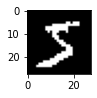

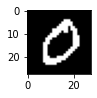

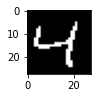

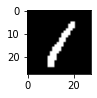

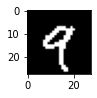

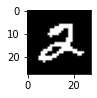

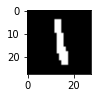

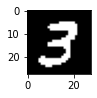

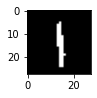

In [ ]:
from matplotlib import pyplot
for i in range(9):  
  pyplot.subplot(330 + 1 + i)
  pyplot.imshow(train_images[i], cmap=pyplot.get_cmap('gray'))
  pyplot.show()

In [ ]:


def imgtodf(img):
  arr = np.empty((0 ,784), int)
  for i in img:
    array_1d = np.array(i).flatten()
    array_1d = array_1d.reshape(1,784)
    arr = np.append(arr, np.array(array_1d), axis=0)
    df = pd.DataFrame(arr)
    print
  return df

X_train = imgtodf(train_images)
X_test = imgtodf(test_images)



In [ ]:
X_train.to_csv('/content/drive/MyDrive/pattern//Train.csv', index=False)
X_test.to_csv('/content/drive/MyDrive/pattern//Test.csv', index=False)

In [40]:
xtrain = pd.read_csv('/content/drive/MyDrive/pattern//Train.csv')
xtest = pd.read_csv('/content/drive/MyDrive/pattern//Test.csv')

In [41]:
ytrain = pd.DataFrame(train_lables)
ytest =  pd.DataFrame(test_lables)

# **All Features**

## **All Features SVM RBF**

In [ ]:


%%time

classifier = OneVsRestClassifier(SVC(kernel='rbf', random_state=1))
classifier.fit(xtrain,ytrain)


ypred_rbf = classifier.predict(xtest)
ypred_rbf_dfunction = classifier.fit(xtrain,ytrain).decision_function(xtest)
print("Accuracy:", metrics.accuracy_score(ytest, ypred_rbf))



Accuracy: 0.9763
CPU times: user 1h 27min 50s, sys: 6.44 s, total: 1h 27min 57s
Wall time: 1h 27min 29s


In [ ]:
#confusion matrix
print('confusion ' , confusion_matrix(ytest, ypred_rbf))

#precision
print('Precision:' ,  precision_score(ytest, ypred_rbf, average='weighted'))


#recall

print('Recal :' , recall_score(ytest, ypred_rbf, average='weighted'))


#f1 score
print('f1 score  ' , f1_score(ytest,ypred_rbf, average= 'weighted'))


confusion  [[ 971    0    1    0    0    1    3    1    3    0]
 [   0 1125    3    0    0    1    5    0    1    0]
 [   6    1 1002    2    3    0    2    7    8    1]
 [   0    0    2  987    0    5    0    6    5    5]
 [   1    0    4    0  960    0    3    1    2   11]
 [   2    1    0    8    0  871    5    1    3    1]
 [   4    3    0    0    4    2  943    0    2    0]
 [   0   12   10    4    1    2    0  991    0    8]
 [   2    0    1    6    3    5    1    5  948    3]
 [   4    5    1    7   10    4    1    8    4  965]]
Precision: 0.9762809007774417
Recal : 0.9763
f1 score   0.9762751987672579


 0  is : 0.9996625412914613 

 1  is : 0.9998390939968346 

 2  is : 0.9991110727893838 

 3  is : 0.998565843236159 

 4  is : 0.9995194042781148 

 5  is : 0.9994805729354375 

 6  is : 0.999445870558133 

 7  is : 0.9983490574220532 

 8  is : 0.9991835132000595 

 9  is : 0.9970328218318528 



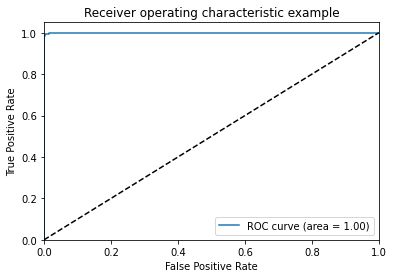

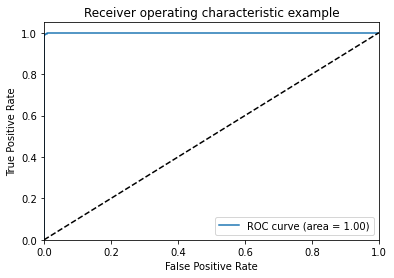

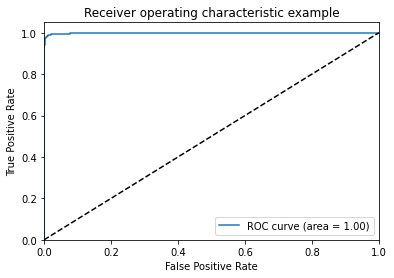

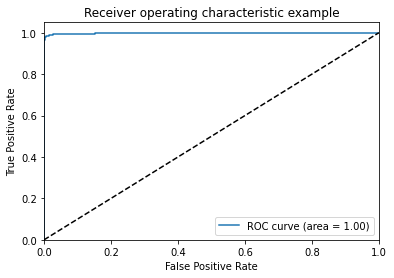

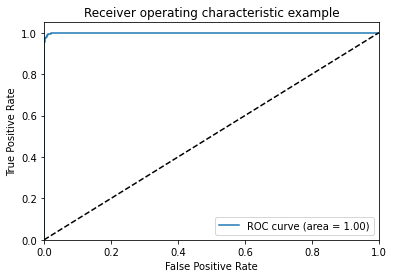

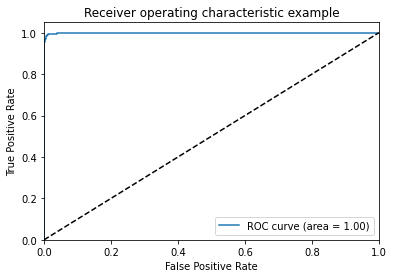

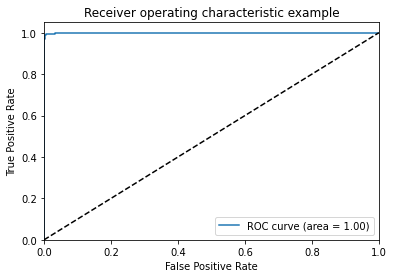

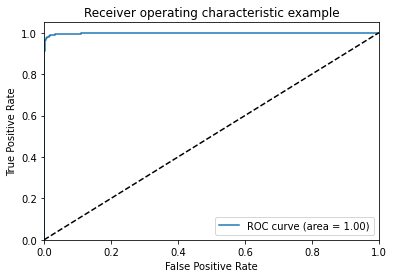

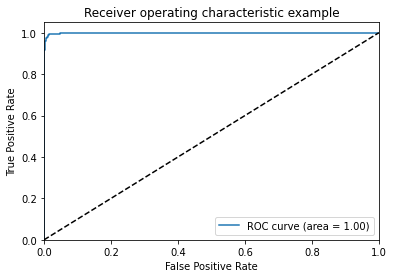

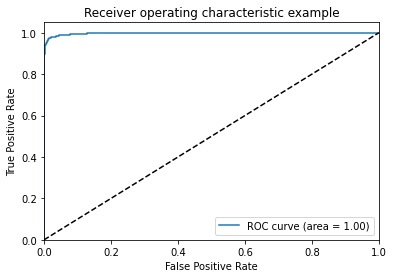

In [ ]:

ybinerized_labels = label_binarize(ytest, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ybinerized_labels[:, i], ypred_rbf_dfunction[:, i])
    roc_auc[i] =  (fpr[i], tpr[i])
    print(' {0}  is :'.format(i),roc_auc[i], "\n")
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # This is added back by InteractiveShellApp.init_path()


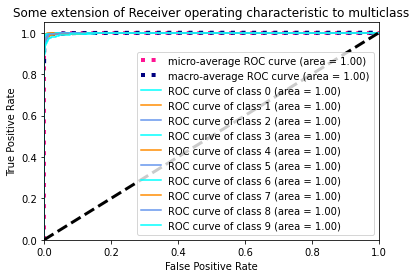

In [ ]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(ybinerized_labels.ravel(), ypred_rbf_dfunction.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
n_classes = 10
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()





## **All Features Linear SVC**

In [ ]:
%%time
clftotal = OneVsRestClassifier(make_pipeline(StandardScaler(),
                     LinearSVC(random_state=0, tol=1e-5)))
clftotal.fit(xtrain, ytrain)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

CPU times: user 12min 35s, sys: 848 ms, total: 12min 36s
Wall time: 12min 33s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [ ]:
ypred_linear = clftotal.predict(xtest)
ypredlinearrbf_dfunction = clftotal.fit(xtrain,ytrain).decision_function(xtest)
print("Accuracy:", metrics.accuracy_score(ytest, ypred_linear))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

Accuracy: 0.9031


In [ ]:
#confusion matrix
print('confusion ' , confusion_matrix(ytest, ypred_linear))

#precision
print('Precision:' ,  precision_score(ytest, ypred_linear, average='weighted'))


#recall

print('Recal :' , recall_score(ytest, ypred_linear, average='weighted'))


#f1 score
print('f1 score  ' , f1_score(ytest,ypred_linear, average= 'weighted'))

confusion  [[ 947    0    5    1    0   13    5    7    2    0]
 [   0 1111    4    3    0    2    4    0   10    1]
 [   9   12  881   29   11    5   20   11   48    6]
 [   6    3   14  914    3   34    3   13   14    6]
 [   1    2    6    3  893    1   11    4   13   48]
 [  10    5    4   34   13  769   13   11   26    7]
 [   9    4    5    2    8   25  899    2    4    0]
 [   1   12   22   10    6    4    3  916    2   52]
 [  10   18    8   33   15   36   14   14  814   12]
 [   8    7    5   16   38    9    0   27   12  887]]
Precision: 0.9030272730524131
Recal : 0.9031
f1 score   0.9028154058781447


In [45]:
# Binarize the output
ybinerized_labels = label_binarize(ytest, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


 0  is : 0.9971450065613829 

 1  is : 0.9962656688307977 

 2  is : 0.9779379222593337 

 3  is : 0.98220718289849 

 4  is : 0.9904753742119744 

 5  is : 0.9718319134019076 

 6  is : 0.9939791527268479 

 7  is : 0.9864714216819817 

 8  is : 0.9599786107303065 

 9  is : 0.9718238225010607 



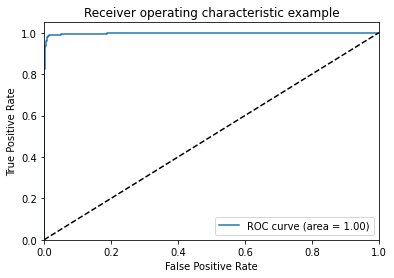

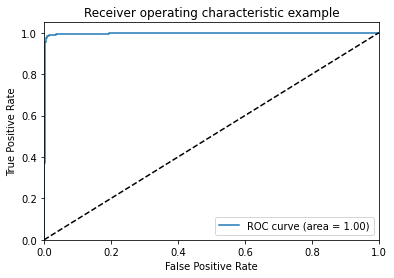

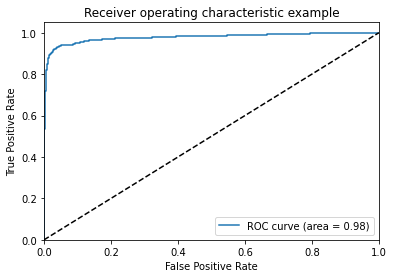

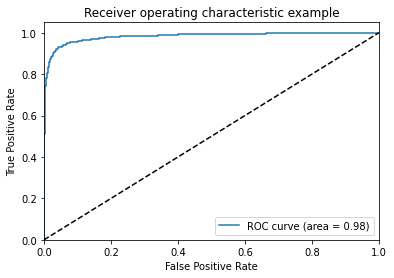

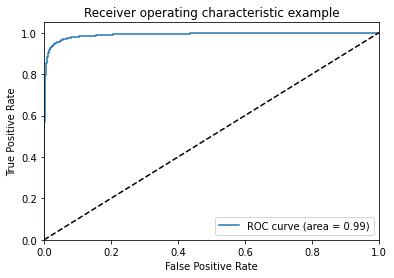

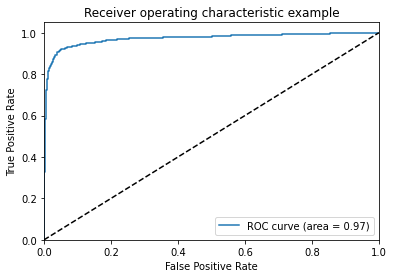

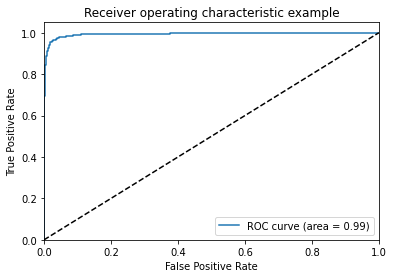

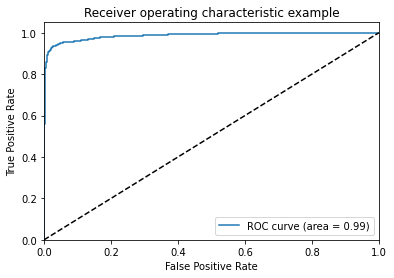

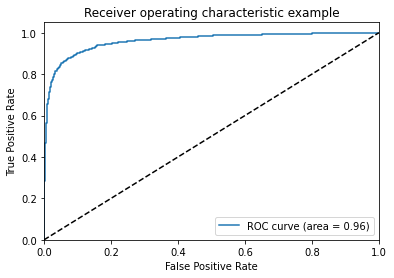

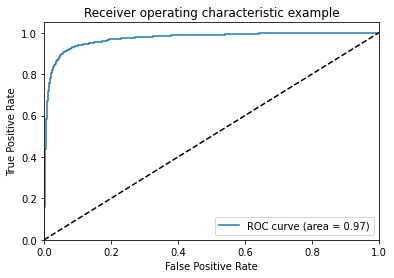

In [ ]:



n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ybinerized_labels[:, i], ypredlinearrbf_dfunction[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(' {0}  is :'.format(i),roc_auc[i], "\n")
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  if sys.path[0] == '':


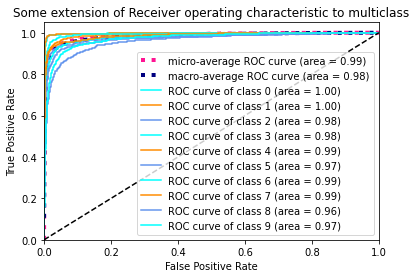

In [ ]:
# Compute micro-average ROC curve and ROC area

fpr["micro"], tpr["micro"], _ = roc_curve(ybinerized_labels.ravel(), ypredlinearrbf_dfunction.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
n_classes = 10
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()



## **All Features Decision Tree**

In [ ]:
clf = OneVsRestClassifier(DecisionTreeClassifier())
clf.fit(xtrain,ytrain)
ypred_tree = clf.predict(xtest)
ypred_dec = clf.fit(xtrain, ytrain).predict_proba(xtest)
print("Accuracy:", metrics.accuracy_score(ytest, ypred_tree))


Accuracy: 0.8536


/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:502: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


In [ ]:
print('confusion matrix :' ,confusion_matrix(ytest, ypred_tree))

print('precision :' ,precision_score(ytest, ypred_tree , average= 'weighted'))

print('recall :' , recall_score(ytest, ypred_tree,average= 'weighted'))
 

print('f1score :', f1_score(ytest,ypred_tree, average= 'weighted'))



confusion matrix : [[ 854    1   11    6    7   26   16    6    7   46]
 [   0 1070    8    5    0    1    9    4   10   28]
 [   1    2  796   33   12    5   14   11   53  105]
 [   2    2   10  804    6   30    3   17   24  112]
 [   1    3    5    2  793    2    6   19   25  126]
 [   2    1    1    3    0  712   12    6   39  116]
 [   5    0    2    1    3    7  864    0   19   57]
 [   2    2    7    4    2    1    0  884   10  116]
 [   5    5    4    6    6   10    5    0  795  138]
 [   3    3    2    6    9    4    0   15    3  964]]
precision : 0.8860926734490293
recall : 0.8536
f1score : 0.8612234132697606


In [ ]:
ypred_dec_df = pd.DataFrame(ypred_dec)
ypred_dec_df= ypred_dec_df.fillna(0)
ypred_dec = ypred_dec_df.to_numpy()

 0  is : 0.9714837775464954 

 1  is : 0.9847922955939682 

 2  is : 0.9262448114398135 

 3  is : 0.9297421227106024 

 4  is : 0.929877064156367 

 5  is : 0.93085022579076 

 6  is : 0.9586703133001687 

 7  is : 0.9456594641175051 

 8  is : 0.916959493245841 

 9  is : 0.9156893927293662 



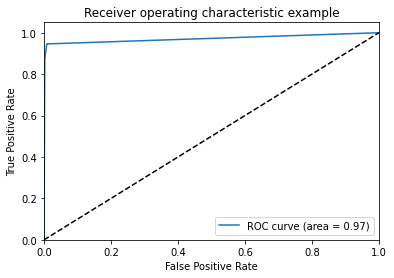

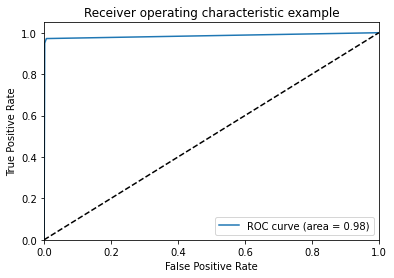

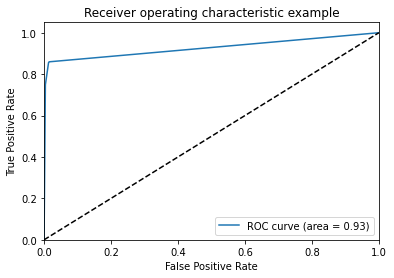

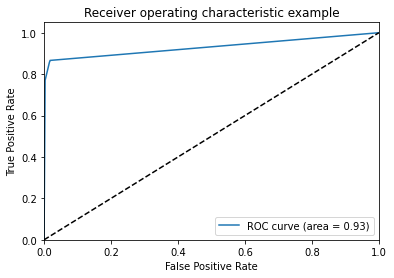

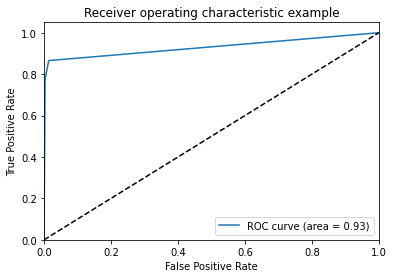

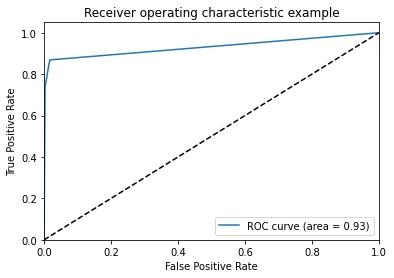

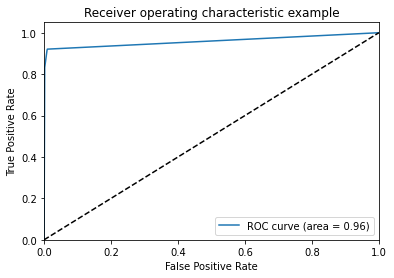

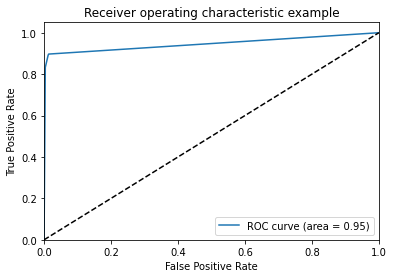

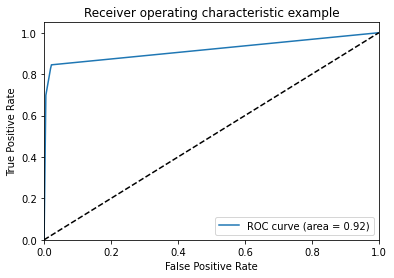

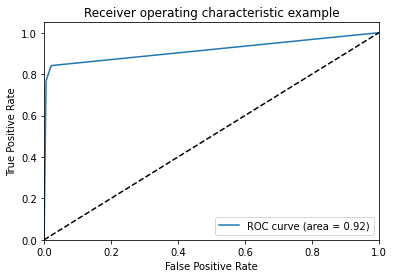

In [ ]:


n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ybinerized_labels[:, i], ypred_dec[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(' {0}  is :'.format(i),roc_auc[i], "\n")
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # This is added back by InteractiveShellApp.init_path()


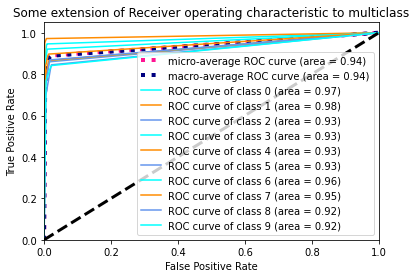

In [ ]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(ybinerized_labels.ravel(), ypred_dec.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
n_classes = 10
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()



# **PCA**

In [13]:


pca_40 = PCA(n_components=40)

xtrain_pca40 = pca_40.fit(xtrain)

xtest_pca40 = pca_40.fit(xtest)

pca_100 = PCA(n_components=100)

xtrain_pca100 = pca_100.fit(xtrain)

xtest_pca100 = pca_100.fit(xtest)




In [14]:

xtest_pca100 = xtest_pca100.transform(xtest)
xtrain_pca40 = xtrain_pca40.transform(xtrain)

xtest_pca40 = xtest_pca40.transform(xtest)
xtrain_pca100 = xtrain_pca100.transform(xtrain)




## **PCA 40**

### **PCA 40 - RBF SVC**

In [ ]:


%%time

classifier = OneVsRestClassifier(SVC(kernel='rbf', random_state=1))
classifier.fit(xtrain_pca40,ytrain)


ypred_rbf40 = classifier.predict(xtest_pca40)
ypred_rbf_dfunction40 = classifier.fit(xtrain_pca40,ytrain).decision_function(xtest_pca40)
print("Accuracy:", metrics.accuracy_score(ytest, ypred_rbf40))

Accuracy: 0.981
CPU times: user 5min 28s, sys: 476 ms, total: 5min 28s
Wall time: 5min 29s


In [ ]:
print('confusion matrix :' ,confusion_matrix(ytest, ypred_rbf40))

print('precision :' ,precision_score(ytest, ypred_rbf40 , average= 'weighted'))

print('recall :' , recall_score(ytest, ypred_rbf40,average= 'weighted'))

print('f1score :', f1_score(ytest,ypred_rbf40, average= 'weighted'))

confusion matrix : [[ 974    0    1    0    0    1    1    2    1    0]
 [   0 1127    2    1    0    2    2    0    1    0]
 [   4    0 1011    1    1    0    2    8    5    0]
 [   0    0    2  989    0    4    0    6    4    5]
 [   0    0    1    0  960    0    4    1    2   14]
 [   2    0    0    8    0  877    2    1    1    1]
 [   4    2    0    0    3    2  945    0    2    0]
 [   0    9    9    0    1    0    0  998    2    9]
 [   2    0    1    5    0    2    1    5  955    3]
 [   4    4    0    3   10    3    1    7    3  974]]
precision : 0.9809946239066647
recall : 0.981
f1score : 0.9809913594723032


 0  is : 0.9997495361781076 

 1  is : 0.9999571646155871 

 2  is : 0.999573526716871 

 3  is : 0.99966585535083 

 4  is : 0.9997552981838992 

 5  is : 0.9997198540286862 

 6  is : 0.9996470888117109 

 7  is : 0.9987453400202273 

 8  is : 0.9995339723572922 

 9  is : 0.9985492595337326 



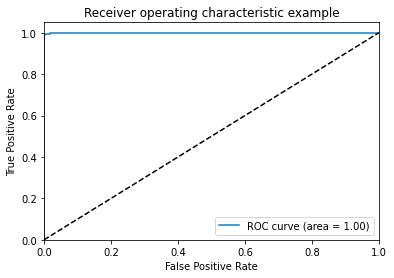

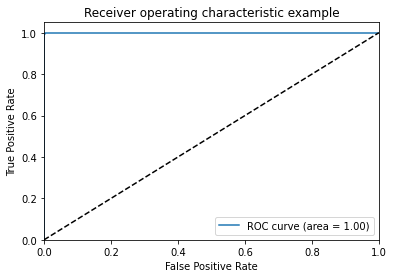

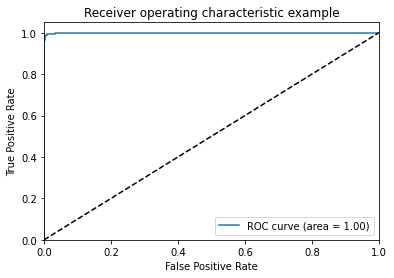

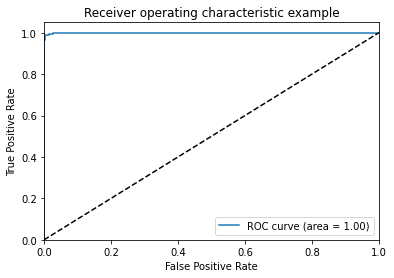

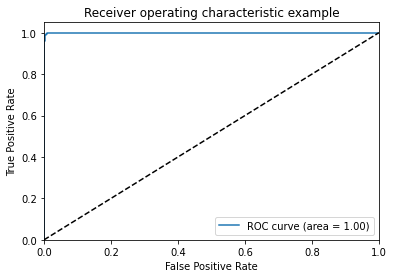

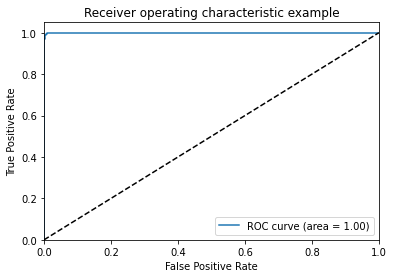

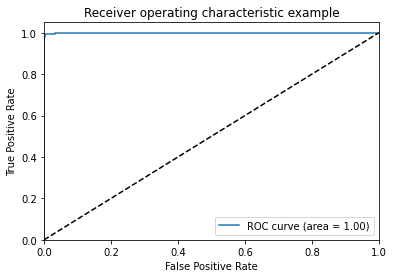

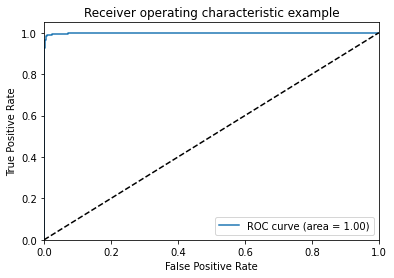

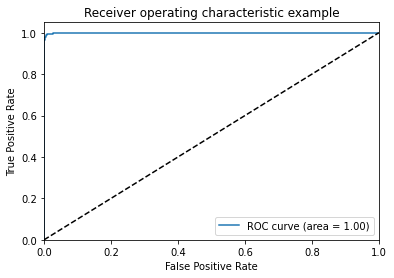

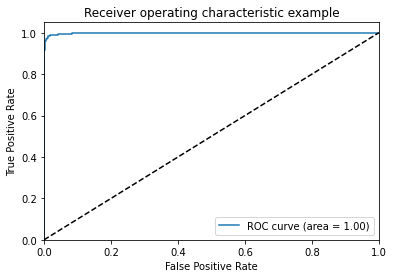

In [ ]:
n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ybinerized_labels[:, i], ypred_rbf_dfunction40[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(' {0}  is :'.format(i),roc_auc[i], "\n")
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # This is added back by InteractiveShellApp.init_path()


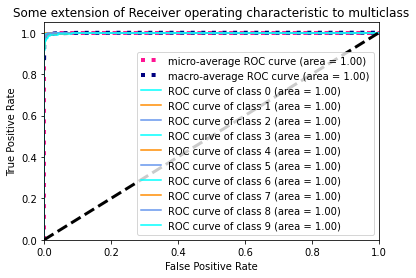

In [ ]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(ybinerized_labels.ravel(), ypred_rbf_dfunction40.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
n_classes = 10
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

### **PCA 40 - Decision Tree**

In [ ]:
clf40 = OneVsRestClassifier(DecisionTreeClassifier())
clf40.fit(xtrain_pca40,ytrain)
ypred_tree_40 = clf40.predict(xtest_pca40)
ypred_dec40 = clf40.fit(xtrain_pca40, ytrain).predict_proba(xtest_pca40)
print("Accuracy:", metrics.accuracy_score(ytest, ypred_tree_40))

Accuracy: 0.7918


/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:502: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


In [ ]:
print('confusion matrix :' ,confusion_matrix(ytest, ypred_tree_40))

print('precision :' ,precision_score(ytest, ypred_tree_40 , average= 'weighted'))

print('recall :' , recall_score(ytest, ypred_tree_40,average= 'weighted'))
 

print('f1score :', f1_score(ytest,ypred_tree_40, average= 'weighted'))


confusion matrix : [[ 796    0   21   19    3   33   24    7   11   66]
 [   0 1075    2    4    3    0    9    3   10   29]
 [   5    3  724   40   18   13   15   23   39  152]
 [   2    3    6  720    7   60   13   13   40  146]
 [   3    2    5    0  695   14   20   19   20  204]
 [   2    3    7   18    7  594   23   10   47  181]
 [   7    3    4    0    7    8  820    4   26   79]
 [   0    7    8    4    7    4    0  814    9  175]
 [   4    1    7   24    6   15    8    8  725  176]
 [   2    3    0    5   31   12    2   15    9  930]]
precision : 0.8406431755401769
recall : 0.7893
f1score : 0.8013896449811853


In [ ]:
ypred_dec_df40 = pd.DataFrame(ypred_dec40)
ypred_dec_df40= ypred_dec_df40.fillna(0)
ypred_dec40 = ypred_dec_df40.to_numpy()

 0  is : 0.9580374111950767 

 1  is : 0.9823016813633777 

 2  is : 0.8985115682633861 

 3  is : 0.8983925483760834 

 4  is : 0.8947521341115009 

 5  is : 0.8619753048126025 

 6  is : 0.9421191018115876 

 7  is : 0.9109525896390154 

 8  is : 0.8641844504877764 

 9  is : 0.8778098658067824 



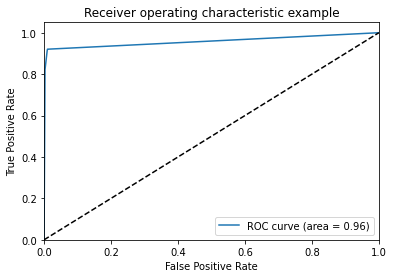

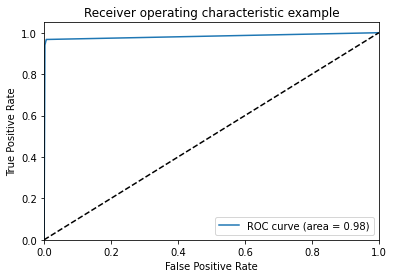

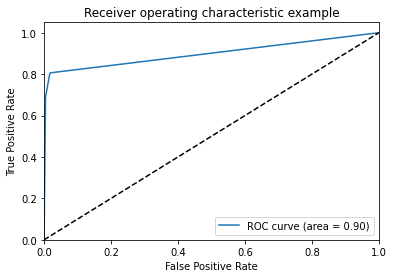

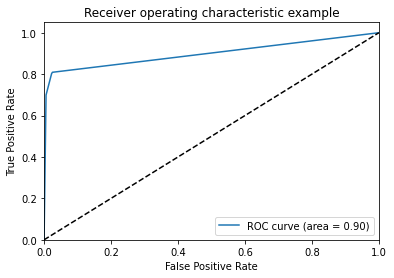

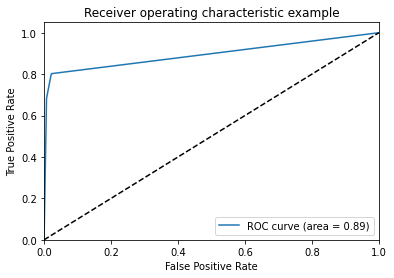

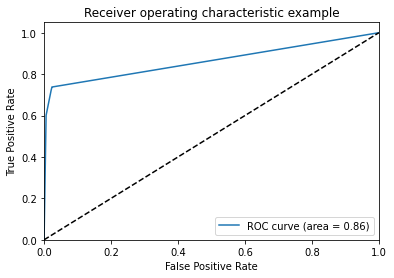

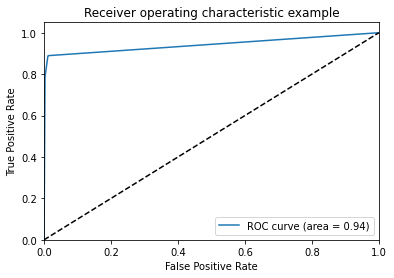

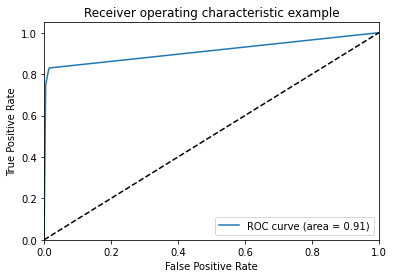

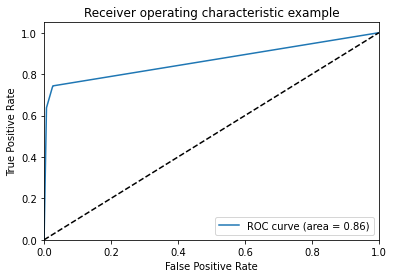

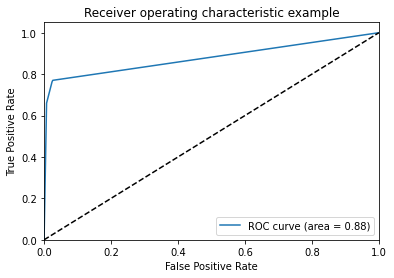

In [ ]:


n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ybinerized_labels[:, i], ypred_dec40[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(' {0}  is :'.format(i),roc_auc[i], "\n")
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # This is added back by InteractiveShellApp.init_path()


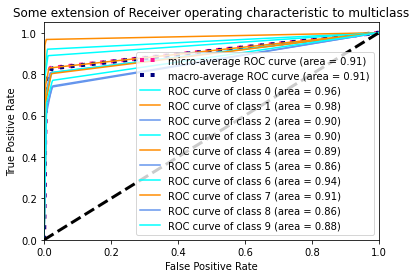

In [ ]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(ybinerized_labels.ravel(), ypred_dec40.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
n_classes = 10
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()


### **PCA 40 - Linear SVC**

In [ ]:

%%time
clflinearpca40 = OneVsRestClassifier(make_pipeline(StandardScaler(),
                     LinearSVC(random_state=0, tol=1e-5)))
clflinearpca40.fit(xtrain_pca40, ytrain)
ypred_linear_pca40 = clflinearpca40.predict(xtest_pca40)
ypredlinearrbf_dfunction_pca40 = clflinearpca40.fit(xtrain_pca40,ytrain).decision_function(xtest_pca40)
print("Accuracy:", metrics.accuracy_score(ytest, ypred_linear_pca40))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

Accuracy: 0.8885
CPU times: user 1min 56s, sys: 364 ms, total: 1min 57s
Wall time: 1min 57s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [ ]:
print('confusion matrix :' ,confusion_matrix(ytest, ypred_linear_pca40))

print('precision :' ,precision_score(ytest, ypred_linear_pca40 , average= 'weighted'))

print('recall :' , recall_score(ytest, ypred_linear_pca40,average= 'weighted'))

print('f1score :', f1_score(ytest,ypred_linear_pca40, average= 'weighted'))


confusion matrix : [[ 953    0    3    2    2    9    7    2    2    0]
 [   0 1106    3    2    0    1    4    1   17    1]
 [   9   13  878   19   18    3   16   23   46    7]
 [   4    1   25  895    1   33    5   13   19   14]
 [   4    6   10    2  883    1    6    1   10   59]
 [  16    6    6   65   26  690   22   11   33   17]
 [  14    3    8    2   15   18  894    0    4    0]
 [   1   20   28    6   13    0    0  933    2   25]
 [  15   12   14   31   15   42   13   13  810    9]
 [  10    9    6   12   54   19    1   37   18  843]]
precision : 0.8878176391757097
recall : 0.8885
f1score : 0.8877851679254042


 0  is : 0.9981343047196706 

 1  is : 0.9976527004430134 

 2  is : 0.9708196974254715 

 3  is : 0.980311347041267 

 4  is : 0.9883615886579409 

 5  is : 0.9489890619984206 

 6  is : 0.9932085664717517 

 7  is : 0.9865861322124517 

 8  is : 0.960974933923491 

 9  is : 0.9643566041539832 



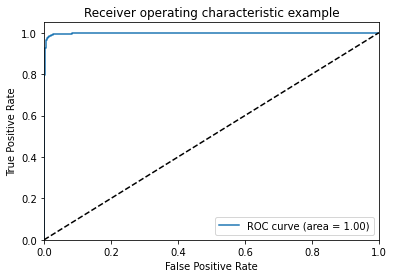

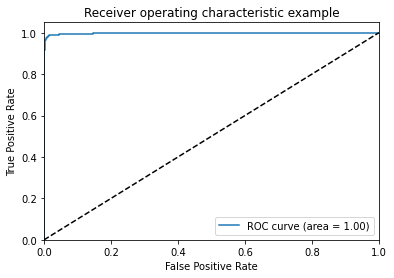

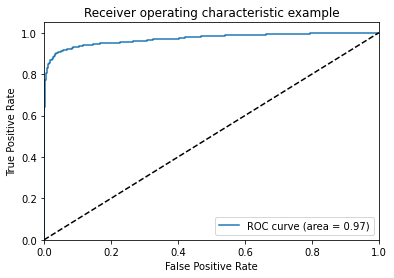

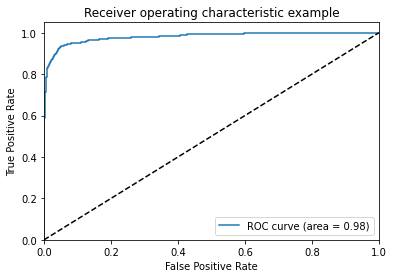

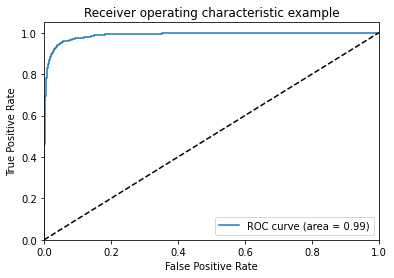

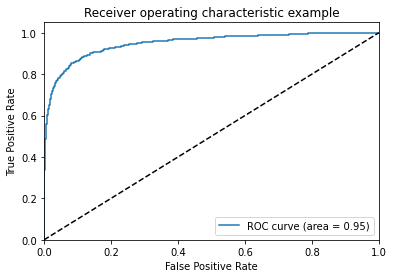

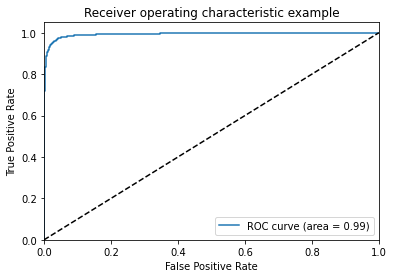

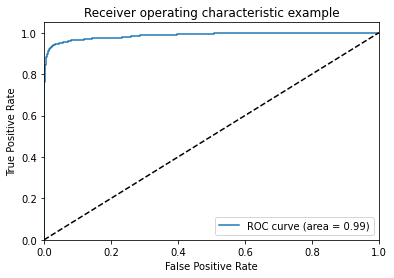

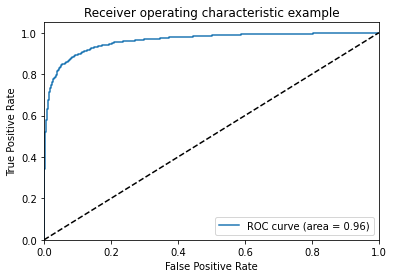

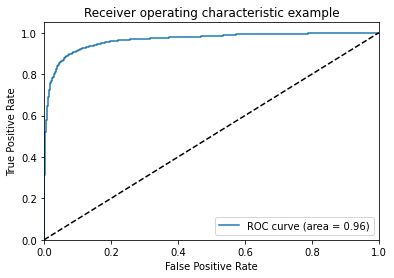

In [ ]:


n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ybinerized_labels[:, i], ypredlinearrbf_dfunction_pca40[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(' {0}  is :'.format(i),roc_auc[i], "\n")
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # This is added back by InteractiveShellApp.init_path()


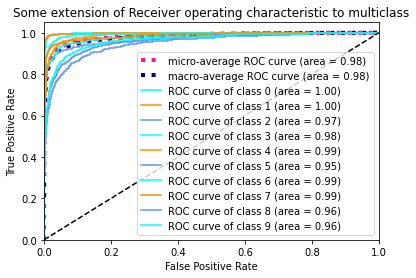

In [ ]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(ybinerized_labels.ravel(), ypredlinearrbf_dfunction_pca40.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
n_classes = 10
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

## **PCA 100**

### **PCA 100 - RBF SVC**

In [ ]:
%%time

classifier100 = OneVsRestClassifier(SVC(kernel='rbf', random_state=1))
classifier100.fit(xtrain_pca100,ytrain)


ypred_rbf100 = classifier100.predict(xtest_pca100)
ypred_rbf_dfunction100 = classifier100.fit(xtrain_pca100,ytrain).decision_function(xtest_pca100)
print("Accuracy:", metrics.accuracy_score(ytest, ypred_rbf100))

Accuracy: 0.9823
CPU times: user 13min 19s, sys: 1.25 s, total: 13min 20s
Wall time: 13min 20s


In [ ]:
print('confusion matrix :' ,confusion_matrix(ytest, ypred_rbf100))

print('precision :' ,precision_score(ytest, ypred_rbf100 , average= 'weighted'))

print('recall :' , recall_score(ytest, ypred_rbf100,average= 'weighted'))

print('f1score :', f1_score(ytest,ypred_rbf100, average= 'weighted'))


confusion matrix : [[ 974    0    1    0    0    1    2    1    1    0]
 [   0 1129    3    0    0    2    1    0    0    0]
 [   4    0 1012    1    1    0    2    7    5    0]
 [   0    0    3  991    0    4    0    6    4    2]
 [   0    0    2    0  962    0    4    1    2   11]
 [   2    0    0    7    0  877    3    1    1    1]
 [   4    2    0    0    4    3  944    0    1    0]
 [   1    8    9    2    1    0    0 1000    1    6]
 [   2    0    1    2    1    1    2    2  959    4]
 [   4    4    1    3    9    2    1    7    3  975]]
precision : 0.9822889892292578
recall : 0.9823
f1score : 0.9822862910985685


 0  is : 0.9997271369745238 

 1  is : 0.9999560713691172 

 2  is : 0.9995796855659053 

 3  is : 0.9993662925803148 

 4  is : 0.9997415217087888 

 5  is : 0.999735609162398 

 6  is : 0.9997214345118282 

 7  is : 0.9989381144277658 

 8  is : 0.9996629631668676 

 9  is : 0.9980953313185447 



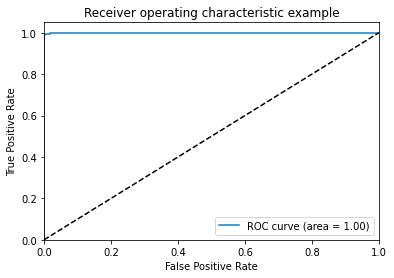

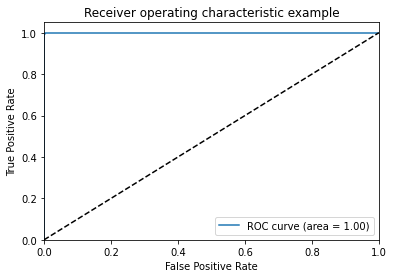

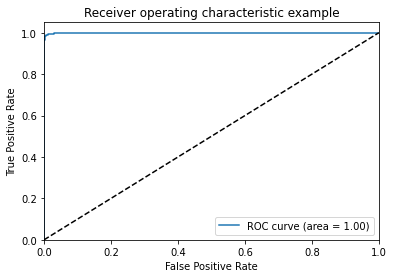

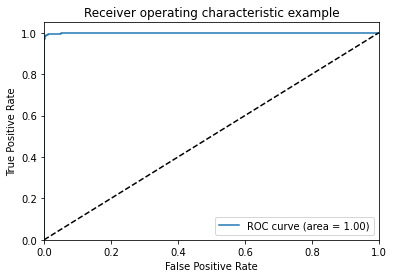

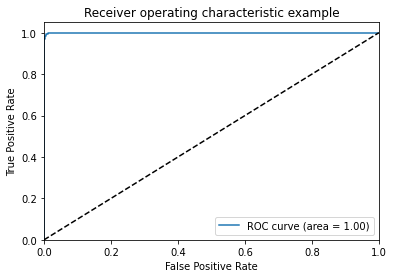

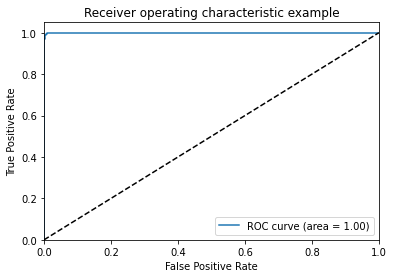

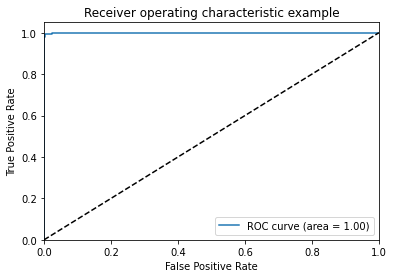

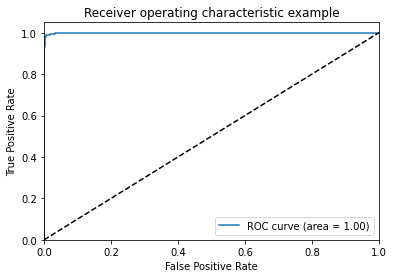

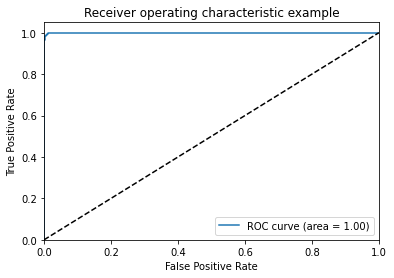

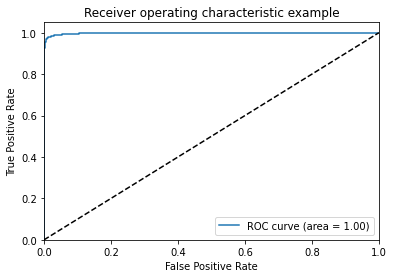

In [ ]:
n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ybinerized_labels[:, i], ypred_rbf_dfunction100[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(' {0}  is :'.format(i),roc_auc[i], "\n")
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # This is added back by InteractiveShellApp.init_path()


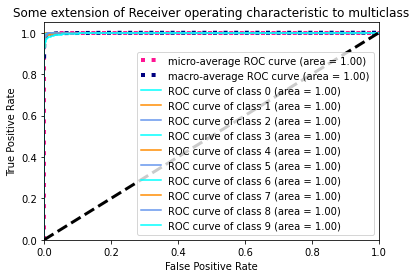

In [ ]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(ybinerized_labels.ravel(), ypred_rbf_dfunction100.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
n_classes = 10
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

### **PCA 100 - Decision Tree**

In [42]:
clf100 = OneVsRestClassifier(DecisionTreeClassifier())
clf100.fit(xtrain_pca100,ytrain)
ypred_tree_100 = clf100.predict(xtest_pca100)
ypred_dec100 = clf100.fit(xtrain_pca100, ytrain).predict_proba(xtest_pca100)
print("Accuracy:", metrics.accuracy_score(ytest, ypred_tree_100))

Accuracy: 0.7757


/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:502: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


In [43]:
ypred_dec_df100 = pd.DataFrame(ypred_dec100)
ypred_dec_df100= ypred_dec_df100.fillna(0)
ypred_dec100 = ypred_dec_df100.to_numpy()

In [50]:
print('confusion matrix :' ,confusion_matrix(ytest, ypred_tree_100))

print('precision :' ,precision_score(ytest, ypred_tree_100 , average= 'weighted'))

print('recall :' , recall_score(ytest, ypred_tree_100,average= 'weighted'))

print('f1score :', f1_score(ytest,ypred_tree_100, average= 'weighted'))


confusion matrix : [[ 800    0   26   17    9   31   22    5   10   60]
 [   0 1079    5    5    0    0    7    1   10   28]
 [   6    3  723   29   22   11   15   17   47  159]
 [   2    0    5  722    2   59    9   11   42  158]
 [   0    3    7    6  662   15   21   20   15  233]
 [   2    0    4   17    3  574   21   13   67  191]
 [   4    3    3    4    9   16  806    9   25   79]
 [   1    9    7    4    8    4    0  788   20  187]
 [   4    2    9   29   11   19    8    7  675  210]
 [   2    6    1    6   23    9    2   20   12  928]]
precision : 0.8326937670193192
recall : 0.7757
f1score : 0.7892529519515006


 0  is : 0.9577549889135255 

 1  is : 0.9828494972308565 

 2  is : 0.8912850773464999 

 3  is : 0.8965432989350104 

 4  is : 0.8907877275546215 

 5  is : 0.8628554382782789 

 6  is : 0.9369065908617591 

 7  is : 0.9111373408147441 

 8  is : 0.8546292344588824 

 9  is : 0.8563225156662003 



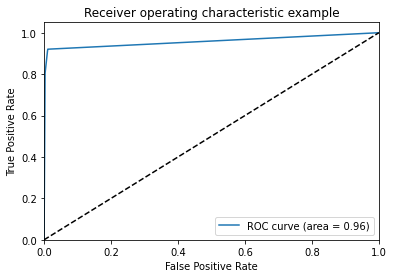

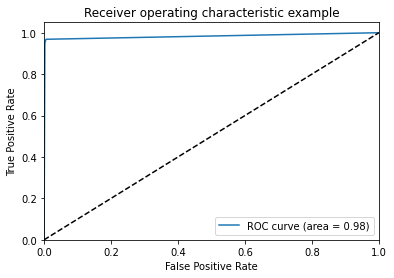

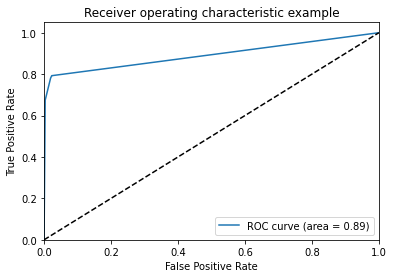

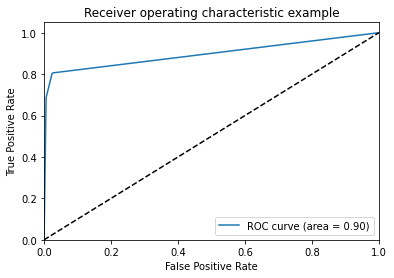

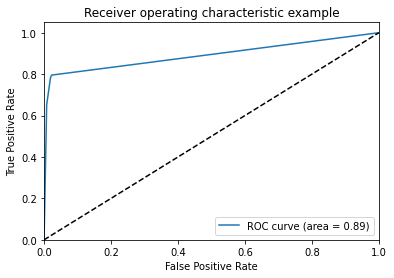

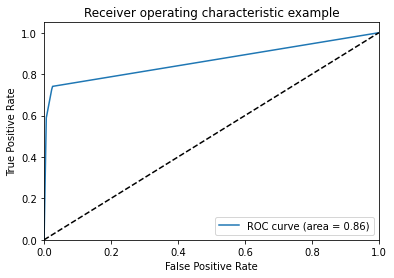

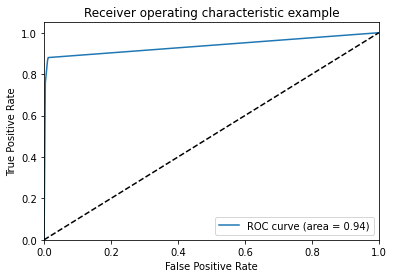

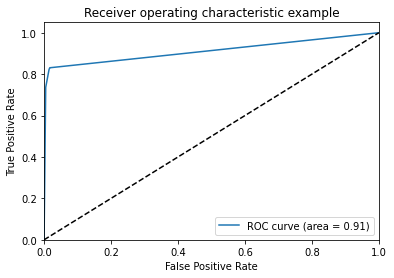

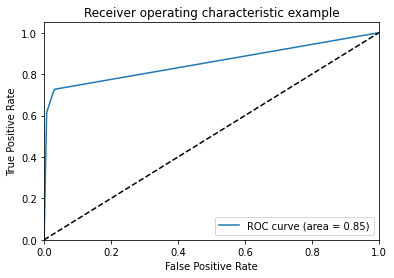

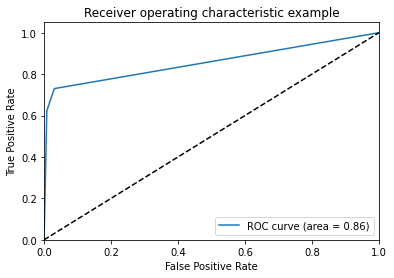

In [46]:


n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ybinerized_labels[:, i], ypred_dec100[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(' {0}  is :'.format(i),roc_auc[i], "\n")
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # This is added back by InteractiveShellApp.init_path()


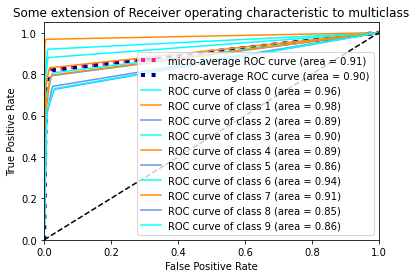

In [48]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(ybinerized_labels.ravel(), ypred_dec100.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
n_classes = 10
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", )
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

### **PCA 100 - Linear SVC**

In [ ]:
clflinearpca100 = OneVsRestClassifier(make_pipeline(StandardScaler(),
                     LinearSVC(random_state=0, tol=1e-5)))
clflinearpca100.fit(xtrain_pca100, ytrain)

ypred_linear_pca100 = clflinearpca100.predict(xtest_pca100)
ypredlinearrbf_dfunction_pca100 = clflinearpca100.fit(xtrain_pca100,ytrain).decision_function(xtest_pca100)
print("Accuracy:", metrics.accuracy_score(ytest, ypred_linear_pca100))


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

Accuracy: 0.9047


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [ ]:
print('confusion matrix :' ,confusion_matrix(ytest, ypred_linear_pca100))

print('precision :' ,precision_score(ytest, ypred_linear_pca100 , average= 'weighted'))

print('recall :' , recall_score(ytest, ypred_linear_pca100,average= 'weighted'))

print('f1score :', f1_score(ytest,ypred_linear_pca100, average= 'weighted'))


confusion matrix : [[ 956    0    1    3    1    7    6    2    2    2]
 [   0 1114    2    2    0    0    4    1   11    1]
 [   8   12  902   16   12    3   16   16   42    5]
 [   6    1   19  904    2   27    5   16   20   10]
 [   3    3    6    1  894    0   11    4   11   49]
 [  12    6    7   46   14  741   19    7   28   12]
 [   9    3    6    1   10   14  909    1    5    0]
 [   2   17   24    5   10    3    0  933    1   33]
 [  12   12    7   26   17   38   13   14  824   11]
 [   8    5    2   13   46   13    1   38   13  870]]
precision : 0.9042552910875491
recall : 0.9047
f1score : 0.904249479975958


 0  is : 0.9983144033666681 

 1  is : 0.9981279644993055 

 2  is : 0.9762146330795456 

 3  is : 0.9834968446789062 

 4  is : 0.9905459504164336 

 5  is : 0.9657393539607422 

 6  is : 0.9950579734839827 

 7  is : 0.9894406679839224 

 8  is : 0.9658706697648729 

 9  is : 0.9702089491760233 



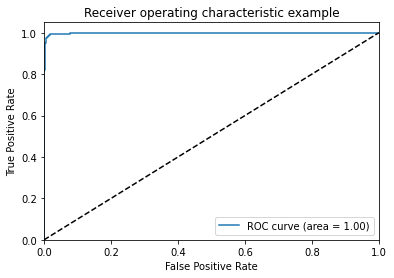

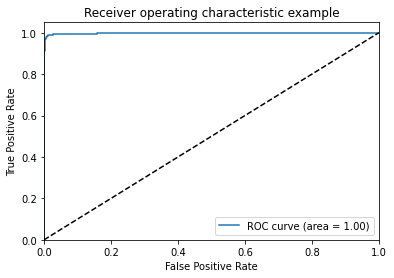

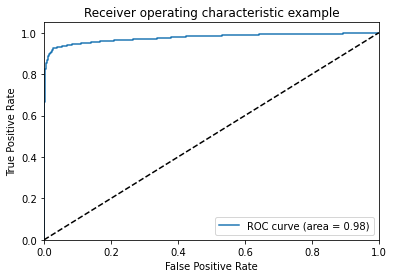

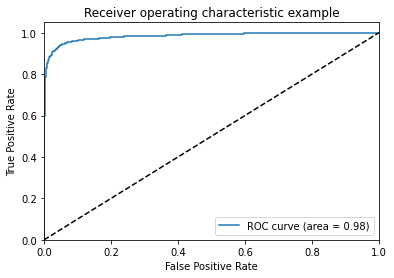

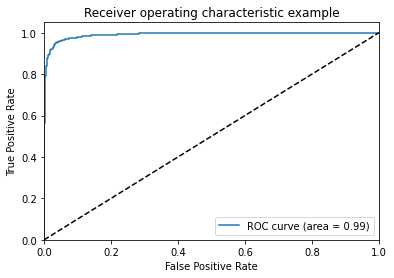

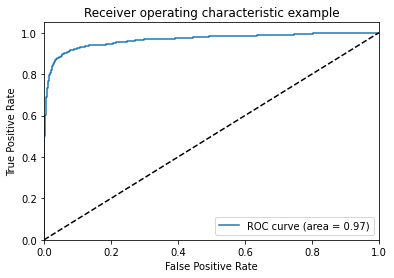

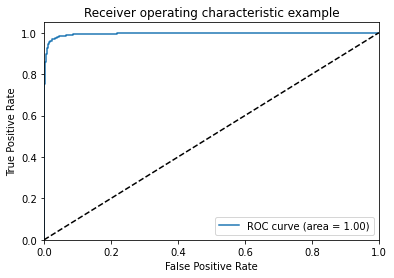

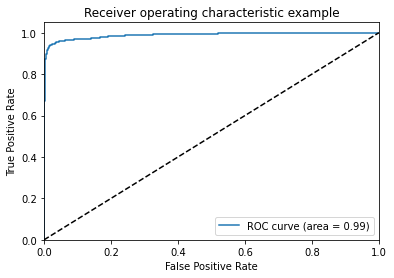

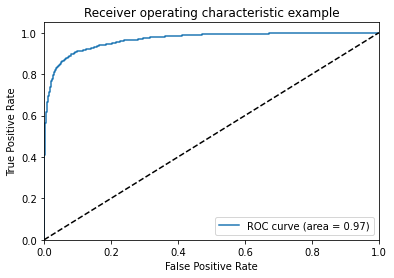

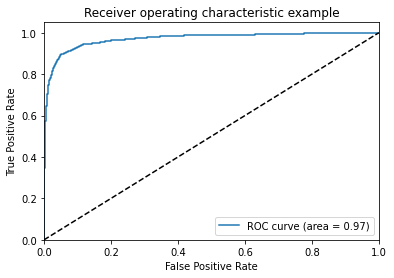

In [ ]:


n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ybinerized_labels[:, i], ypredlinearrbf_dfunction_pca100[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(' {0}  is :'.format(i),roc_auc[i], "\n")
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # This is added back by InteractiveShellApp.init_path()


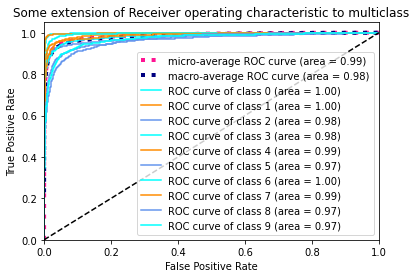

In [ ]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(ybinerized_labels.ravel(), ypredlinearrbf_dfunction_pca100.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
n_classes = 10
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

# **BOUNUS**

## **Linear SVC , K = 5**

In [33]:
xtrain_pca100 = pd.DataFrame(xtrain_pca100)
xtest_pca100 = pd.DataFrame(xtest_pca100)
Xconcat_100 = [xtrain_pca100, xtest_pca100]
yconcat = [ytrain, ytest]
x_100 = pd.concat(Xconcat_100)
y = pd.concat(yconcat)

In [35]:
k = 5
kf = KFold(n_splits=k, random_state=None)
model_SVM_linear = OneVsRestClassifier(make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5)))

In [36]:
accuracyscore_linear = []
for train_index, test_index in kf.split(X):
  xtrain , xtest = x_100.iloc[train_index,:],x_100.iloc[test_index,:]
  ytrain , ytest = y.iloc[train_index] , y.iloc[test_index]
  
  model_SVM_linear.fit(xtrain, ytrain)
  predvalues_linear = model_SVM_linear.predict(xtest)
  acc_linear = metrics.accuracy_score(predvalues_linear, ytest)
  accuracyscore_linear.append(acc_linear)

avg_accuracyscore_linear = sum(accuracyscore_linear)/k

print('accuracy of each fold - {}'.format(accuracyscore_linear))
print('Avg accuracy : {}'.format(avg_accuracyscore_linear))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

accuracy of each fold - [0.8992142857142857, 0.8974285714285715, 0.8926428571428572, 0.8968571428571429, 0.9117142857142857]
Avg accuracy : 0.8995714285714286


## **Linear SVC , K = 7**

In [9]:
k = 7
kf = KFold(n_splits=k, random_state=None)
model_SVM_linear = OneVsRestClassifier(make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5)))

In [37]:
%%time 
accuracyscore_linear = []
for train_index, test_index in kf.split(X):
  xtrain , xtest =  x_100.iloc[train_index,:], x_100.iloc[test_index,:]
  ytrain , ytest = y.iloc[train_index] , y.iloc[test_index]
  
  model_SVM_linear.fit(xtrain, ytrain)
  predvalues_linear = model_SVM_linear.predict(xtest)
  acc_linear = metrics.accuracy_score(predvalues_linear, ytest)
  accuracyscore_linear.append(acc_linear)

avg_accuracyscore_linear = sum(accuracyscore_linear)/k

print('accuracy of each fold - {}'.format(accuracyscore_linear))
print('Avg accuracy : {}'.format(avg_accuracyscore_linear))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

accuracy of each fold - [0.8992142857142857, 0.8974285714285715, 0.8926428571428572, 0.8968571428571429, 0.9117142857142857]
Avg accuracy : 0.8995714285714286
CPU times: user 14min 2s, sys: 2.39 s, total: 14min 4s
Wall time: 14min


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


## **Linear SVC , K = 10**

In [62]:
k = 10
kf = KFold(n_splits=k, random_state=None)
model_SVM_linear = OneVsRestClassifier(make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5)))

In [63]:
%%time 
accuracyscore_linear = []
for train_index, test_index in kf.split(X):
  xtrain , xtest =  x_100.iloc[train_index,:], x_100.iloc[test_index,:]
  ytrain , ytest = y.iloc[train_index] , y.iloc[test_index]
  
  model_SVM_linear.fit(xtrain, ytrain)
  predvalues_linear = model_SVM_linear.predict(xtest)
  acc_linear = metrics.accuracy_score(predvalues_linear, ytest)
  accuracyscore_linear.append(acc_linear)

avg_accuracyscore_linear = sum(accuracyscore_linear)/k

print('accuracy of each fold - {}'.format(accuracyscore_linear))
print('Avg accuracy : {}'.format(avg_accuracyscore_linear))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

accuracy of each fold - [0.9064285714285715, 0.8925714285714286, 0.895, 0.9005714285714286, 0.8892857142857142, 0.8981428571428571, 0.8928571428571429, 0.899, 0.906, 0.9187142857142857]
Avg accuracy : 0.8998571428571429
CPU times: user 30min 15s, sys: 4.27 s, total: 30min 20s
Wall time: 30min 11s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


## **RBF SVC , K= 5**

In [27]:
xtrain_pca100 = pd.DataFrame(xtrain_pca100)
xtest_pca100 = pd.DataFrame(xtest_pca100)
Xconcat_100 = [xtrain_pca100, xtest_pca100]
yconcat = [ytrain, ytest]
x_100 = pd.concat(Xconcat_100)
y = pd.concat(yconcat)

In [29]:
k = 5
kf = KFold(n_splits=k, random_state=None)
model_rbf = OneVsRestClassifier(SVC(kernel='rbf', random_state=1))


In [30]:
accuracyscore_rbf = []
for train_index, test_index in kf.split(X):
  xtrain , xtest = x_100.iloc[train_index,:],x_100.iloc[test_index,:]
  ytrain , ytest = y.iloc[train_index] , y.iloc[test_index]
  
  model_rbf.fit(xtrain, ytrain)
  predvalues_rbf = model_rbf.predict(xtest)
  acc_rbf = metrics.accuracy_score(predvalues_rbf, ytest)
  accuracyscore_rbf.append(acc_rbf)

avg_accuracyscore_rbf = sum(accuracyscore_rbf)/k

print('accuracy of each fold - {}'.format(accuracyscore_rbf))
print('Avg accuracy : {}'.format(avg_accuracyscore_rbf))

accuracy of each fold - [0.9807142857142858, 0.9795714285714285, 0.9802857142857143, 0.9769285714285715, 0.9825714285714285]
Avg accuracy : 0.9800142857142857


## **RBF SVC , K= 7**

In [31]:
k = 7
kf = KFold(n_splits=k, random_state=None)
model_rbf = OneVsRestClassifier(SVC(kernel='rbf', random_state=1))


In [32]:
accuracyscore_rbf = []
for train_index, test_index in kf.split(X):
  xtrain , xtest = x_100.iloc[train_index,:],x_100.iloc[test_index,:]
  ytrain , ytest = y.iloc[train_index] , y.iloc[test_index]
  
  model_rbf.fit(xtrain, ytrain)
  predvalues_rbf = model_rbf.predict(xtest)
  acc_rbf = metrics.accuracy_score(predvalues_rbf, ytest)
  accuracyscore_rbf.append(acc_rbf)

avg_accuracyscore_rbf = sum(accuracyscore_rbf)/k

print('accuracy of each fold - {}'.format(accuracyscore_rbf))
print('Avg accuracy : {}'.format(avg_accuracyscore_rbf))

accuracy of each fold - [0.9814, 0.9819, 0.9786, 0.9808, 0.9763, 0.9814, 0.9823]
Avg accuracy : 0.9803857142857143


## **RBF SVC , K= 10**

In [51]:
k = 10
kf = KFold(n_splits=k, random_state=None)
model_rbf = OneVsRestClassifier(SVC(kernel='rbf', random_state=1))

In [64]:
accuracyscore_rbf = []
for train_index, test_index in kf.split(X):
  xtrain , xtest = x_100.iloc[train_index,:],x_100.iloc[test_index,:]
  ytrain , ytest = y.iloc[train_index] , y.iloc[test_index]
  
  model_rbf.fit(xtrain, ytrain)
  predvalues_rbf = model_rbf.predict(xtest)
  acc_rbf = metrics.accuracy_score(predvalues_rbf, ytest)
  accuracyscore_rbf.append(acc_rbf)

avg_accuracyscore_rbf = sum(accuracyscore_rbf)/k

print('accuracy of each fold - {}'.format(accuracyscore_rbf))
print('Avg accuracy : {}'.format(avg_accuracyscore_rbf))

accuracy of each fold - [0.7784285714285715, 0.764, 0.7698571428571429, 0.7701428571428571, 0.771, 0.765, 0.7675714285714286, 0.7688571428571429, 0.7695714285714286, 0.7968571428571428]
Avg accuracy : 0.7721285714285714


## **DecisionTree , k = 5**

In [55]:
xconcat = [xtrain, xtest]
yconcat = [ytrain, ytest]
Xtree = pd.concat(xconcat)
ytree = pd.concat(yconcat)

In [56]:
k = 5
kf = KFold(n_splits=k, random_state=None)
model_tree = OneVsRestClassifier(DecisionTreeClassifier())


In [57]:
accuracyscore_tree = []
for train_index, test_index in kf.split(X):
  xtrain , xtest = Xtree.iloc[train_index,:],Xtree.iloc[test_index,:]
  ytrain , ytest = ytree.iloc[train_index] , ytree.iloc[test_index]
  
  model_tree.fit(xtrain, ytrain)
  predvalues_tree = model_tree.predict(xtest)
  acc_tree = metrics.accuracy_score(predvalues_tree, ytest)
  accuracyscore_tree.append(acc_tree)

avg_accuracyscore_tree = sum(accuracyscore_tree)/k

print('accuracy of each fold - {}'.format(accuracyscore_tree))
print('Avg accuracy : {}'.format(avg_accuracyscore_tree))

accuracy of each fold - [0.8457142857142858, 0.8437142857142857, 0.8365714285714285, 0.8458571428571429, 0.8572142857142857]
Avg accuracy : 0.8458142857142856


## **DecisionTree , k = 7**

In [58]:
k = 7
kf = KFold(n_splits=k, random_state=None)
model_tree = OneVsRestClassifier(DecisionTreeClassifier())


In [59]:
accuracyscore_tree = []
for train_index, test_index in kf.split(X):
  xtrain , xtest = Xtree.iloc[train_index,:],Xtree.iloc[test_index,:]
  ytrain , ytest = ytree.iloc[train_index] , ytree.iloc[test_index]
  
  model_tree.fit(xtrain, ytrain)
  predvalues_tree = model_tree.predict(xtest)
  acc_tree = metrics.accuracy_score(predvalues_tree, ytest)
  accuracyscore_tree.append(acc_tree)

avg_accuracyscore_tree = sum(accuracyscore_tree)/k

print('accuracy of each fold - {}'.format(accuracyscore_tree))
print('Avg accuracy : {}'.format(avg_accuracyscore_tree))

accuracy of each fold - [0.848, 0.8363, 0.8518, 0.8411, 0.8434, 0.8573, 0.8571]
Avg accuracy : 0.8478571428571428


## **DecisionTree , k = 10**

In [60]:
k = 10
kf = KFold(n_splits=k, random_state=None)
model_tree = OneVsRestClassifier(DecisionTreeClassifier())

In [61]:
accuracyscore_tree = []
for train_index, test_index in kf.split(X):
  xtrain , xtest = Xtree.iloc[train_index,:],Xtree.iloc[test_index,:]
  ytrain , ytest = ytree.iloc[train_index] , ytree.iloc[test_index]
  
  model_tree.fit(xtrain, ytrain)
  predvalues_tree = model_tree.predict(xtest)
  acc_tree = metrics.accuracy_score(predvalues_tree, ytest)
  accuracyscore_tree.append(acc_tree)

avg_accuracyscore_tree = sum(accuracyscore_tree)/k

print('accuracy of each fold - {}'.format(accuracyscore_tree))
print('Avg accuracy : {}'.format(avg_accuracyscore_tree))

accuracy of each fold - [0.8538571428571429, 0.8492857142857143, 0.8487142857142858, 0.8557142857142858, 0.8478571428571429, 0.8431428571428572, 0.8431428571428572, 0.8458571428571429, 0.852, 0.8708571428571429]
Avg accuracy : 0.8510428571428573
